## Multi-Class Prediction of Obesity Risk

#### 1. Importado de librerías

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

#### 2. Lectura de datos

In [129]:
df_train = pd.read_csv('train.csv').drop(columns='id')
df_test = pd.read_csv('test.csv').drop(columns='id')
df_sample = pd.read_csv('sample_submission.csv')

In [130]:
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [131]:
df_test.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [132]:
print("Las dimensiones de df_train son:", df_train.shape)
print("Las dimensiones de df_test son:", df_test.shape)

Las dimensiones de df_train son: (20758, 17)
Las dimensiones de df_test son: (13840, 16)


In [133]:
df_train.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [134]:
df_test.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

Vemos que las variables no presentan datos nulos por lo que procedemos

#### 3. EDA

In [135]:
df_train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [136]:
df_train.NObeyesdad.value_counts()

Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: NObeyesdad, dtype: int64

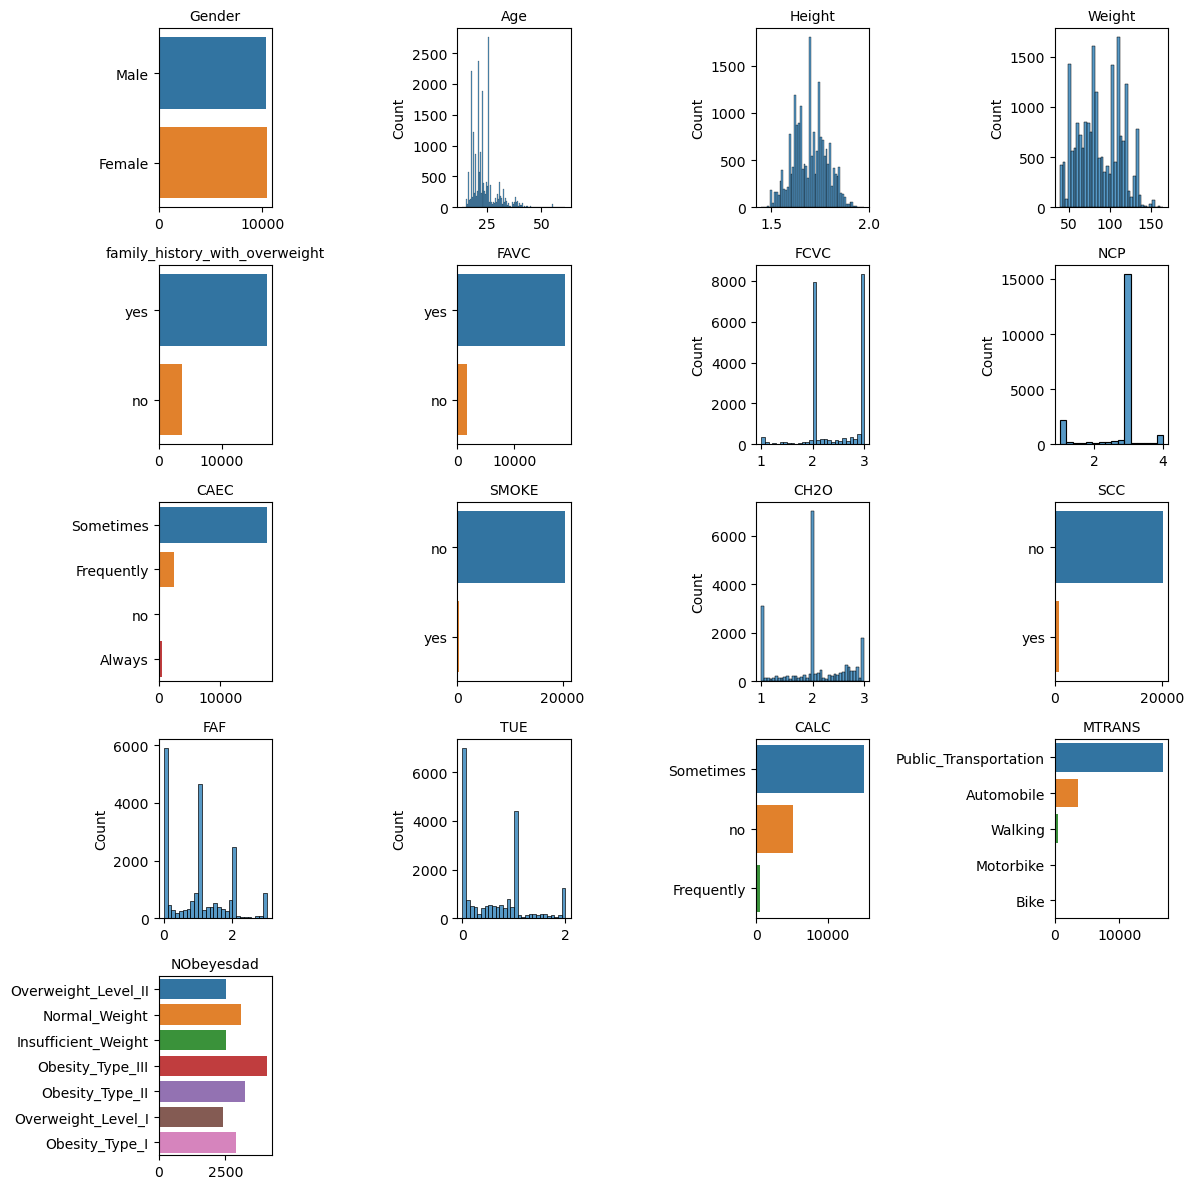

In [137]:
#grafico de atributos
cols = 4
rows = int(df_train.shape[1] / cols)+1
size_fact = 3
plt.figure(figsize=(12, cols*size_fact))

for i, col in enumerate(df_train):
    if df_train[col].dtype == 'object':
        plt.subplot(rows, cols, i + 1)
        sns.countplot(y = df_train[col])
        plt.title(col, fontsize=10)
        plt.xlabel('')
        plt.ylabel('')
    else:
        plt.subplot(rows, cols, i + 1)
        sns.histplot(df_train[col])
        plt.title(col, fontsize=10)
        plt.xlabel('')
plt.tight_layout()

#### 4. Feature Engineering

In [138]:
#recodificación del vector objetivo
encoder = LabelEncoder()
df_train['NObeyesdad'] = encoder.fit_transform(df_train['NObeyesdad'])
df_train['NObeyesdad'].value_counts()

4    4046
3    3248
1    3082
2    2910
0    2523
6    2522
5    2427
Name: NObeyesdad, dtype: int64

In [139]:
#nuevas caracteristicas
def add_features(df):
    df['IMC'] = df['Weight'] / (df['Height'] ** 2)

    return df

In [140]:
df_train['MTRANS'].value_counts()

Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: MTRANS, dtype: int64

In [141]:
#funcion para recodificar el resto de las variables
def feature_engineere(df):
    #transformación de variables binarias con Label encoder
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'yes': 1, 'no': 0})
    df['FAVC'] = df['FAVC'].map({'yes': 1, 'no': 0})
    df['SMOKE'] = df['SMOKE'].map({'yes': 1, 'no': 0})
    df['SCC'] = df['SCC'].map({'yes': 1, 'no': 0})
    #nuevas
    df['DoSport'] = df['MTRANS'].map({'Public_Transportation' : 0, 'Automobile': 0, 'Walking': 1, 'Motorbike': 0, 'Bike': 1})
    df = df.drop(columns='MTRANS')


    #Transformación de variables categóricas de varios parámetros con get dummies
    df['CALC'] = np.where(df['CALC'] == 'Always', 'Frequently', df['CALC'])
    df = pd.get_dummies(columns=['CAEC','CALC'], data=df, drop_first=True)

    #ajustar las columnas con variables continuas mediante un standar scaller
    cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'IMC']
    df[cols] = StandardScaler().fit_transform(df[cols])

    return df

In [142]:
#agregar características
df_train = add_features(df_train)
df_test = add_features(df_test)

#recodificación de variables
df_train_resample = feature_engineere(df_train)
df_test_resample = feature_engineere(df_test)

print("Las dimensiones del df_train_resample son: ", df_train_resample.shape)
print("Las dimensiones del df_test_reample son: ", df_test_resample.shape)
df_test_resample.head()

Las dimensiones del df_train_resample son:  (20758, 21)
Las dimensiones del df_test_reample son:  (13840, 20)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,IMC,DoSport,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Sometimes,CALC_no
0,0,0.508163,1.682789,1.273786,1,1,0.932524,0.350808,0,1.298389,0,-0.141769,-1.005016,0.627659,0,0,1,0,1,0
1,1,-0.509128,-1.114658,-0.818988,1,1,-0.833161,-2.462523,0,1.583678,0,0.030307,-1.005016,-0.524822,0,0,1,0,1,0
2,1,0.353000,-0.626191,0.927432,1,1,1.047997,0.350808,0,0.965029,0,-1.159701,-0.592995,1.353985,0,0,1,0,1,0
3,0,-0.512705,-1.642760,0.623672,1,1,-0.833161,0.319733,0,1.234234,0,-1.046828,-1.005016,1.553777,0,0,1,0,1,0
4,1,0.353000,-0.805996,0.668336,1,1,1.047997,0.350808,0,1.016818,0,-1.159701,0.213881,1.143659,0,0,1,0,1,0


#### 5. Modelamiento

In [143]:
#función para mostrar los mejores parametros en una búsqueda de grilla
def mejores_hiperparametros(model):
    print(f"Mejores parametros encontrados: {model.best_params_}")

#función para mostrar el accuracy del modelo
def accuracy(model, X_test, y_test):
    mejor_modelo = model.best_estimator_
    y_pred = mejor_modelo.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Mejor puntuación: {accuracy}")

In [144]:
#separación de los vectores
X = df_train_resample.drop(columns='NObeyesdad')
y = df_train_resample['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
#creación del modelo XGBoost
#parametros de la grilla
parametros = {'learning_rate': [0.1, 0.01, 0.001],
              'n_estimators': [100, 200, 300],
              'max_depth': [3, 4, 5]}

#inicializar modelo
model = xgb.XGBClassifier()

#Grid search
grid_search = GridSearchCV(model, parametros, cv=2, scoring='accuracy')

#entrenamiento
grid_search.fit(X_train, y_train)

mejores_hiperparametros(grid_search)

#evaluar modelo
accuracy(grid_search, X_test, y_test)

Mejores parametros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Mejor puntuación: 0.905587668593449


In [146]:
#guardado de mejores parametros encontrados en la grilla
mejores_params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

In [147]:
#creación del modelo final con los mejores parametros encontrados
modelo_final = xgb.XGBClassifier(mejores_params).fit(X_train, y_train)
y_pred = modelo_final.predict(X_test)

In [148]:
#Presición del modelo final
presicion = accuracy_score(y_test, y_pred)
print("Presición del mejor modelo (Accuracy):", presicion)

Presición del mejor modelo (Accuracy): 0.9039017341040463


Version 1: 0.9022157996146436
V2: 0.904383429672447

Encontramos que el modelo predice la clasicación con una presición del 90.4%

#### 6. Entrega de resultados

In [149]:
#predicciones de la muestra a entregar para el concurso
y_hat_pred = modelo_final.predict(df_test_resample)

#recuper
y_hat_pred_original = encoder.inverse_transform(y_hat_pred)
#copia del dataframe para entregar resultados
entrega = df_sample.copy()

entrega['NObeyesdad'] = y_hat_pred_original

entrega.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [150]:
#paso del DF a un CSV
entrega.to_csv('resultados.csv', index=False)